In [116]:
import numpy as np
import pandas as pd
import numba
import sys
import os 
sys.path.append('/Users/gk/repos/pp2/Non-stationary-point-process')
from pointprocess.simulation.hawkes_exp import HawkesExp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Reload modules to pick up changes
import importlib

# Import modules first
import pointprocess.estimation.mle
import pointprocess.testing.increments
import pointprocess.testing.transformations
import pointprocess.testing.one_run

# Reload in order (increments before simple_tests since simple_tests depends on it)
importlib.reload(pointprocess.estimation.mle)
importlib.reload(pointprocess.testing.increments)
importlib.reload(pointprocess.testing.transformations)
importlib.reload(pointprocess.testing.one_run)

# Now import simple_tests after increments is reloaded
import pointprocess.testing.simple_tests
importlib.reload(pointprocess.testing.simple_tests)

# Import the functions we need
from pointprocess.estimation.mle import fit_hawkes
from pointprocess.testing.one_run import one_run_with_params
from pointprocess.testing.simple_tests import simple_exp_test

In [117]:
data_path = "/Users/gk/Downloads/SG"
result_dict = {}
for i, filepath in enumerate(os.listdir(data_path)):
    if filepath.endswith(".csv.gz"):
        full_path = os.path.join(data_path, filepath)
        df = pd.read_csv(full_path,
                         compression='gzip',
                         parse_dates=["ets"],
                         index_col=0,
                         date_format='%Y%m%d:%H:%M:%S.%f',
                         engine='pyarrow')
        print(f"Processed {filepath} with {len(df)} rows.")
        df = df[df.etype == "T"]
        start_time = df.ets.min()
        event_times = (df.ets - start_time).dt.total_seconds().values
        T = event_times.max()
        
        # Compute inter-event times
        inter_event_times = np.diff(event_times)
        inter_event_times = inter_event_times[inter_event_times > 0]
        
        # Use GMM to estimate betas
        from sklearn.mixture import GaussianMixture
        n_components = 3
        
        # Fit GMM in log space
        log_inter_event = np.log(inter_event_times).reshape(-1, 1)
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(log_inter_event)
        
        # Extract means (in log space) and convert back to get characteristic times
        log_means = gmm.means_.flatten()
        characteristic_times = np.exp(log_means)
        
        # Betas are decay rates = 1 / characteristic_time
        betas = 1.0 / characteristic_times
        betas = np.sort(betas)[::-1]  # Sort descending (fast to slow)
        
        print(f"  Characteristic times: {characteristic_times}")
        print(f"  Estimated betas: {betas}")
        
        # Fit Hawkes with fixed betas
        result = fit_hawkes(event_times, T, H0="multiexp-fixed-betas", betas=betas)
        
        result_dict[i] = {
            "success": result.success,
            "log_likelihood": -result.fun,
            "mu": result.params_dict["mu"],
            "alphas": result.params_dict["alphas"],
            "betas": result.params_dict["betas"],
            "n_events": len(event_times)
        }
        
        print(f"  Fit success: {result.success}, Log-lik: {-result.fun:.2f}")
        print(f"  mu: {result.params_dict['mu']:.6f}")
        print(f"  alphas: {result.params_dict['alphas']}")
        print()


Processed SG_20170127.csv.gz with 680663 rows.
  Characteristic times: [4.53630880e-06 2.27056235e+00 1.05416714e-03]
  Estimated betas: [2.20443546e+05 9.48616178e+02 4.40419528e-01]
  Fit success: True, Log-lik: 43058.82
  mu: 0.099875
  alphas: [9.30323510e+01 5.90637754e+02 7.98302573e-02]

Processed SG_20170125.csv.gz with 539393 rows.
  Characteristic times: [1.27891026e-03 4.60987631e-06 2.35024199e+00]
  Estimated betas: [2.16925560e+05 7.81915693e+02 4.25488100e-01]
  Fit success: True, Log-lik: 59863.71
  mu: 0.124940
  alphas: [7.58005948e+01 5.15008885e+02 6.13571822e-02]

Processed SG_20170117.csv.gz with 841149 rows.
  Characteristic times: [4.66350023e-06 3.60068246e+00 1.48738357e-03]
  Estimated betas: [2.14431210e+05 6.72321530e+02 2.77725129e-01]
  Fit success: True, Log-lik: 50659.69
  mu: 0.104558
  alphas: [9.13181799e+04 1.23095204e+02 4.43263099e-02]

Processed SG_20170123.csv.gz with 569477 rows.
  Characteristic times: [3.76666916e+00 4.55624051e-06 1.30929157

In [118]:
pd.DataFrame.from_dict(result_dict, orient='index').to_csv("hawkes_fixed_betas_fit_results.csv")

In [119]:
from pointprocess.testing.one_run import one_run_with_params
from pointprocess.testing.simple_tests import simple_exp_test

data_path = "/Users/gk/Downloads/SG"
result_dict = {}

for file_idx, filepath in enumerate(os.listdir(data_path)):
    if filepath.endswith(".csv.gz"):
        full_path = os.path.join(data_path, filepath)
        df = pd.read_csv(full_path,
                         compression='gzip',
                         parse_dates=["ets"],
                         index_col=0,
                         date_format='%Y%m%d:%H:%M:%S.%f',
                         engine='pyarrow')
        print(f"\n{'='*60}")
        print(f"Processing {filepath} with {len(df)} rows")
        print(f"{'='*60}")
        
        df = df[df.etype == "T"]
        start_time = df.ets.min()
        event_times = (df.ets - start_time).dt.total_seconds().values
        T_total = event_times.max()
        
        # Split into 15-minute intervals
        interval_duration = 900  # 15 minutes in seconds
        n_intervals = int(np.ceil(T_total / interval_duration))
        
        print(f"Total duration: {T_total:.2f} sec ({T_total/3600:.2f} hours)")
        print(f"Number of 15-minute intervals: {n_intervals}")
        
        for interval_idx in range(n_intervals):
            t_start = interval_idx * interval_duration
            t_end = min((interval_idx + 1) * interval_duration, T_total)
            
            # Extract events in this interval
            interval_events = event_times[(event_times >= t_start) & (event_times < t_end)]
            
            # Skip if too few events
            if len(interval_events) < 50:
                print(f"\nInterval {interval_idx} ({t_start/3600:.2f}-{t_end/3600:.2f}h): SKIPPED (only {len(interval_events)} events)")
                continue
            
            # Shift events to start at 0 for this interval
            interval_events_shifted = interval_events - t_start
            T_interval = t_end - t_start
            
            print(f"\nInterval {interval_idx} ({t_start/3600:.2f}-{t_end/3600:.2f}h): {len(interval_events)} events")
            
            # Compute inter-event times and estimate betas
            inter_event_times = np.diff(interval_events_shifted)
            inter_event_times = inter_event_times[inter_event_times > 0]
            
            # Use GMM to estimate betas
            from sklearn.mixture import GaussianMixture
            n_components = 3
            
            log_inter_event = np.log(inter_event_times).reshape(-1, 1)
            gmm = GaussianMixture(n_components=n_components, random_state=42)
            gmm.fit(log_inter_event)
            
            log_means = gmm.means_.flatten()
            characteristic_times = np.exp(log_means)
            betas = 1.0 / characteristic_times
            betas = np.sort(betas)[::-1]
            
            print(f"  Estimated betas: {betas}")
            
            # Fit Hawkes with fixed betas
            result = fit_hawkes(interval_events_shifted, T_interval, 
                              H0="multiexp-fixed-betas", betas=betas)
            
            print(f"  Fit success: {result.success}, Log-lik: {-result.fun:.2f}")
            print(f"  mu: {result.params_dict['mu']:.6f}")
            print(f"  alphas: {result.params_dict['alphas']}")
            
            # Run Khmaladze GOF tests with the fitted parameters (no re-estimation)
            try:
                ks_reject_k, ad_reject_k, cvm_reject_k = one_run_with_params(
                    interval_events_shifted, T_interval, 
                    params_dict=result.params_dict,
                    H0="multiexp-fixed-betas", 
                    method="khmaladze", 
                    alpha_level=0.05
                )
                
                rejected_count_k = sum([ks_reject_k, ad_reject_k, cvm_reject_k])
                print(f"  Khmaladze Tests: KS={ks_reject_k}, AD={ad_reject_k}, CvM={cvm_reject_k} ({rejected_count_k}/3 rejected)")
                
            except Exception as e:
                print(f"  Khmaladze Tests: FAILED - {e}")
                ks_reject_k, ad_reject_k, cvm_reject_k = None, None, None
                rejected_count_k = None
            
            # Run Naive GOF tests
            try:
                ks_reject_n, ad_reject_n, cvm_reject_n = one_run_with_params(
                    interval_events_shifted, T_interval, 
                    params_dict=result.params_dict,
                    H0="multiexp-fixed-betas", 
                    method="naive", 
                    alpha_level=0.05
                )
                
                rejected_count_n = sum([ks_reject_n, ad_reject_n, cvm_reject_n])
                print(f"  Naive Tests: KS={ks_reject_n}, AD={ad_reject_n}, CvM={cvm_reject_n} ({rejected_count_n}/3 rejected)")
                
            except Exception as e:
                print(f"  Naive Tests: FAILED - {e}")
                ks_reject_n, ad_reject_n, cvm_reject_n = None, None, None
                rejected_count_n = None
            
            # Run Simple Exp Test (time-rescaling)
            try:
                ks_reject_e, ad_reject_e, cvm_reject_e = simple_exp_test(
                    interval_events_shifted, T_interval, 
                    params_dict=result.params_dict,
                    H0="multiexp-fixed-betas", 
                    alpha_level=0.05
                )
                
                rejected_count_e = sum([ks_reject_e, ad_reject_e, cvm_reject_e])
                print(f"  Simple Exp Tests: KS={ks_reject_e}, AD={ad_reject_e}, CvM={cvm_reject_e} ({rejected_count_e}/3 rejected)")
                
            except Exception as e:
                print(f"  Simple Exp Tests: FAILED - {e}")
                ks_reject_e, ad_reject_e, cvm_reject_e = None, None, None
                rejected_count_e = None
            
            # Store results
            key = f"{file_idx}_{interval_idx}"
            result_dict[key] = {
                "file": filepath,
                "interval_idx": interval_idx,
                "t_start_hours": t_start / 3600,
                "t_end_hours": t_end / 3600,
                "n_events": len(interval_events),
                "success": result.success,
                "log_likelihood": -result.fun,
                "mu": result.params_dict["mu"],
                "alphas": result.params_dict["alphas"],
                "betas": result.params_dict["betas"],
                # Khmaladze tests
                "ks_reject_khmaladze": ks_reject_k,
                "ad_reject_khmaladze": ad_reject_k,
                "cvm_reject_khmaladze": cvm_reject_k,
                "rejected_count_khmaladze": rejected_count_k,
                # Naive tests
                "ks_reject_naive": ks_reject_n,
                "ad_reject_naive": ad_reject_n,
                "cvm_reject_naive": cvm_reject_n,
                "rejected_count_naive": rejected_count_n,
                # Simple exp tests
                "ks_reject_exp": ks_reject_e,
                "ad_reject_exp": ad_reject_e,
                "cvm_reject_exp": cvm_reject_e,
                "rejected_count_exp": rejected_count_e,
            }

print(f"\n{'='*60}")
print(f"Processed {len(result_dict)} intervals total")
print(f"{'='*60}")



Processing SG_20170127.csv.gz with 680663 rows
Total duration: 30529.25 sec (8.48 hours)
Number of 15-minute intervals: 34

Interval 0 (0.00-0.25h): 676 events
  Estimated betas: [2.00911435e+05 1.15426092e+03 6.06377318e-01]
  Fit success: True, Log-lik: 2391.77
  mu: 0.128684
  alphas: [1.29649119e+02 7.85106371e+02 8.95937856e-02]
  Khmaladze Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Naive Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Simple Exp Tests: KS=True, AD=True, CvM=True (3/3 rejected)

Interval 1 (0.25-0.50h): 624 events
  Estimated betas: [2.09821506e+05 1.10074046e+03 5.77940593e-01]
  Fit success: True, Log-lik: 1851.32
  mu: 0.125976
  alphas: [1.13106874e+02 6.92347274e+02 1.09590047e-01]
  Khmaladze Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Naive Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Simple Exp Tests: KS=True, AD=True, CvM=True (3/3 rejected)

Interval 2 (0.50-0.75h): 454 events
  Estimated betas: [2.08268714e+05 8.6512

In [120]:
pd.DataFrame.from_dict(result_dict, orient='index').to_csv("hawkes_fixed_betas_per_hour_fit_results.csv")

In [121]:
# Create summary table of rejection proportions
df_results = pd.DataFrame.from_dict(result_dict, orient='index')

# Calculate rejection proportions for each test method
summary_data = {
    'Test Method': [],
    'Statistic': [],
    'Rejection Rate': []
}

# Naive Transformation (Author's method with increments)
for stat in ['ks', 'ad', 'cvm']:
    col_name = f'{stat}_reject_naive'
    if col_name in df_results.columns:
        # Count only non-None values
        valid_tests = df_results[col_name].notna()
        n_valid = valid_tests.sum()
        n_rejected = df_results.loc[valid_tests, col_name].sum()
        rejection_rate = n_rejected / n_valid if n_valid > 0 else 0
        summary_data['Test Method'].append('Naive Transformation')
        summary_data['Statistic'].append(stat.upper())
        summary_data['Rejection Rate'].append(f"{rejection_rate:.2%}")
        print(f"{col_name}: {n_rejected}/{n_valid} = {rejection_rate:.2%}")

# Simple Time Inversion (Exp(1) test)
for stat in ['ks', 'ad', 'cvm']:
    col_name = f'{stat}_reject_exp'
    if col_name in df_results.columns:
        # Count only non-None values
        valid_tests = df_results[col_name].notna()
        n_valid = valid_tests.sum()
        n_rejected = df_results.loc[valid_tests, col_name].sum()
        rejection_rate = n_rejected / n_valid if n_valid > 0 else 0
        summary_data['Test Method'].append('Time Inversion')
        summary_data['Statistic'].append(stat.upper())
        summary_data['Rejection Rate'].append(f"{rejection_rate:.2%}")
        print(f"{col_name}: {n_rejected}/{n_valid} = {rejection_rate:.2%}")

# Khmaladze Transformation
for stat in ['ks', 'ad', 'cvm']:
    col_name = f'{stat}_reject_khmaladze'
    if col_name in df_results.columns:
        # Count only non-None values
        valid_tests = df_results[col_name].notna()
        n_valid = valid_tests.sum()
        n_rejected = df_results.loc[valid_tests, col_name].sum()
        rejection_rate = n_rejected / n_valid if n_valid > 0 else 0
        summary_data['Test Method'].append('Khmaladze')
        summary_data['Statistic'].append(stat.upper())
        summary_data['Rejection Rate'].append(f"{rejection_rate:.2%}")
        print(f"{col_name}: {n_rejected}/{n_valid} = {rejection_rate:.2%}")

print(f"\nSummary data collected: {len(summary_data['Test Method'])} rows")

summary_df = pd.DataFrame(summary_data)
print(f"\nSummary DataFrame shape: {summary_df.shape}")
print(summary_df)

# Create a pivot table for better display
pivot_summary = summary_df.pivot(index='Test Method', columns='Statistic', values='Rejection Rate')

# Reorder rows
row_order = ['Naive Transformation', 'Time Inversion', 'Khmaladze']
pivot_summary = pivot_summary.reindex([r for r in row_order if r in pivot_summary.index])

# Reorder columns
col_order = ['KS', 'AD', 'CVM']
pivot_summary = pivot_summary[[c for c in col_order if c in pivot_summary.columns]]

print("\n" + "="*60)
print("REJECTION RATES BY TEST METHOD")
print("="*60)
print(pivot_summary.to_string())
print("="*60)
print(f"Total intervals tested: {len(df_results)}")
print("="*60)

# Display styled version if in Jupyter
try:
    display(pivot_summary.style.set_caption("Proportion of Intervals Where H0 Was Rejected (α=0.05)"))
except:
    pass

ks_reject_naive: 2/408 = 0.49%
ad_reject_naive: 1/408 = 0.25%
cvm_reject_naive: 1/408 = 0.25%
ks_reject_exp: 407/408 = 99.75%
ad_reject_exp: 408/408 = 100.00%
cvm_reject_exp: 406/408 = 99.51%
ks_reject_khmaladze: 30/408 = 7.35%
ad_reject_khmaladze: 22/408 = 5.39%
cvm_reject_khmaladze: 26/408 = 6.37%

Summary data collected: 9 rows

Summary DataFrame shape: (9, 3)
            Test Method Statistic Rejection Rate
0  Naive Transformation        KS          0.49%
1  Naive Transformation        AD          0.25%
2  Naive Transformation       CVM          0.25%
3        Time Inversion        KS         99.75%
4        Time Inversion        AD        100.00%
5        Time Inversion       CVM         99.51%
6             Khmaladze        KS          7.35%
7             Khmaladze        AD          5.39%
8             Khmaladze       CVM          6.37%

REJECTION RATES BY TEST METHOD
Statistic                 KS       AD     CVM
Test Method                                  
Naive Transformation

In [122]:
# Exponential Hawkes: Fit each day per hour with GOF tests
from pointprocess.testing.one_run import one_run_with_params
from pointprocess.testing.simple_tests import simple_exp_test

data_path = "/Users/gk/Downloads/SG"
result_dict_exp = {}

for file_idx, filepath in enumerate(os.listdir(data_path)):
    if filepath.endswith(".csv.gz"):
        full_path = os.path.join(data_path, filepath)
        df = pd.read_csv(full_path,
                         compression='gzip',
                         parse_dates=["ets"],
                         index_col=0,
                         date_format='%Y%m%d:%H:%M:%S.%f',
                         engine='pyarrow')
        print(f"\n{'='*60}")
        print(f"Processing {filepath} with {len(df)} rows")
        print(f"{'='*60}")
        
        df = df[df.etype == "T"]
        start_time = df.ets.min()
        event_times = (df.ets - start_time).dt.total_seconds().values
        T_total = event_times.max()
        
        # Split into 15-minute intervals
        interval_duration = 900  # 15 minutes in seconds
        n_intervals = int(np.ceil(T_total / interval_duration))
        
        print(f"Total duration: {T_total:.2f} sec ({T_total/3600:.2f} hours)")
        print(f"Number of 15-minute intervals: {n_intervals}")
        
        for interval_idx in range(n_intervals):
            t_start = interval_idx * interval_duration
            t_end = min((interval_idx + 1) * interval_duration, T_total)
            
            # Extract events in this interval
            interval_events = event_times[(event_times >= t_start) & (event_times < t_end)]
            
            # Skip if too few events
            if len(interval_events) < 50:
                print(f"\nInterval {interval_idx} ({t_start/3600:.2f}-{t_end/3600:.2f}h): SKIPPED (only {len(interval_events)} events)")
                continue
            
            # Shift events to start at 0 for this interval
            interval_events_shifted = interval_events - t_start
            T_interval = t_end - t_start
            
            print(f"\nInterval {interval_idx} ({t_start/3600:.2f}-{t_end/3600:.2f}h): {len(interval_events)} events")
            
            # Fit exponential Hawkes
            result = fit_hawkes(interval_events_shifted, T_interval, H0="exp")
            
            print(f"  Fit success: {result.success}, Log-lik: {-result.fun:.2f}")
            print(f"  mu: {result.params_dict['mu']:.6f}, alpha: {result.params_dict['alpha']:.6f}, beta: {result.params_dict['beta']:.6f}")
            
            # Run Khmaladze GOF tests
            try:
                ks_reject_k, ad_reject_k, cvm_reject_k = one_run_with_params(
                    interval_events_shifted, T_interval, 
                    params_dict=result.params_dict,
                    H0="exp", 
                    method="khmaladze", 
                    alpha_level=0.05
                )
                
                rejected_count_k = sum([ks_reject_k, ad_reject_k, cvm_reject_k])
                print(f"  Khmaladze Tests: KS={ks_reject_k}, AD={ad_reject_k}, CvM={cvm_reject_k} ({rejected_count_k}/3 rejected)")
                
            except Exception as e:
                print(f"  Khmaladze Tests: FAILED - {e}")
                ks_reject_k, ad_reject_k, cvm_reject_k = None, None, None
                rejected_count_k = None
            
            # Run Naive GOF tests
            try:
                ks_reject_n, ad_reject_n, cvm_reject_n = one_run_with_params(
                    interval_events_shifted, T_interval, 
                    params_dict=result.params_dict,
                    H0="exp", 
                    method="naive", 
                    alpha_level=0.05
                )
                
                rejected_count_n = sum([ks_reject_n, ad_reject_n, cvm_reject_n])
                print(f"  Naive Tests: KS={ks_reject_n}, AD={ad_reject_n}, CvM={cvm_reject_n} ({rejected_count_n}/3 rejected)")
                
            except Exception as e:
                print(f"  Naive Tests: FAILED - {e}")
                ks_reject_n, ad_reject_n, cvm_reject_n = None, None, None
                rejected_count_n = None
            
            # Run Simple Exp Test (time-rescaling)
            try:
                ks_reject_e, ad_reject_e, cvm_reject_e = simple_exp_test(
                    interval_events_shifted, T_interval, 
                    params_dict=result.params_dict,
                    H0="exp", 
                    alpha_level=0.05
                )
                
                rejected_count_e = sum([ks_reject_e, ad_reject_e, cvm_reject_e])
                print(f"  Simple Exp Tests: KS={ks_reject_e}, AD={ad_reject_e}, CvM={cvm_reject_e} ({rejected_count_e}/3 rejected)")
                
            except Exception as e:
                print(f"  Simple Exp Tests: FAILED - {e}")
                ks_reject_e, ad_reject_e, cvm_reject_e = None, None, None
                rejected_count_e = None
            
            # Store results
            key = f"{file_idx}_{interval_idx}"
            result_dict_exp[key] = {
                "file": filepath,
                "interval_idx": interval_idx,
                "t_start_hours": t_start / 3600,
                "t_end_hours": t_end / 3600,
                "n_events": len(interval_events),
                "success": result.success,
                "log_likelihood": -result.fun,
                "mu": result.params_dict["mu"],
                "alpha": result.params_dict["alpha"],
                "beta": result.params_dict["beta"],
                # Khmaladze tests
                "ks_reject_khmaladze": ks_reject_k,
                "ad_reject_khmaladze": ad_reject_k,
                "cvm_reject_khmaladze": cvm_reject_k,
                "rejected_count_khmaladze": rejected_count_k,
                # Naive tests
                "ks_reject_naive": ks_reject_n,
                "ad_reject_naive": ad_reject_n,
                "cvm_reject_naive": cvm_reject_n,
                "rejected_count_naive": rejected_count_n,
                # Simple exp tests
                "ks_reject_exp": ks_reject_e,
                "ad_reject_exp": ad_reject_e,
                "cvm_reject_exp": cvm_reject_e,
                "rejected_count_exp": rejected_count_e,
            }

print(f"\n{'='*60}")
print(f"Processed {len(result_dict_exp)} intervals total")
print(f"{'='*60}")


Processing SG_20170127.csv.gz with 680663 rows
Total duration: 30529.25 sec (8.48 hours)
Number of 15-minute intervals: 34

Interval 0 (0.00-0.25h): 676 events
  Fit success: True, Log-lik: 2608.79
  mu: 0.317339, alpha: 14092.566834, beta: 23053.860922
  Khmaladze Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Naive Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Simple Exp Tests: KS=True, AD=True, CvM=True (3/3 rejected)

Interval 1 (0.25-0.50h): 624 events
  Fit success: True, Log-lik: 2006.64
  mu: 0.292648, alpha: 4365.726675, beta: 8486.778975
  Khmaladze Tests: KS=False, AD=True, CvM=False (1/3 rejected)
  Naive Tests: KS=False, AD=True, CvM=False (1/3 rejected)
  Simple Exp Tests: KS=True, AD=True, CvM=True (3/3 rejected)

Interval 2 (0.50-0.75h): 454 events
  Fit success: True, Log-lik: 1522.90
  mu: 0.226637, alpha: 12001.119609, beta: 23287.064463
  Khmaladze Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Naive Tests: KS=False, AD=False, CvM=False (0/3 r

In [123]:
# Save exponential Hawkes results
pd.DataFrame.from_dict(result_dict_exp, orient='index').to_csv("hawkes_exp_per_hour_fit_results.csv")

In [124]:
# Summary table for exponential Hawkes
df_results_exp = pd.DataFrame.from_dict(result_dict_exp, orient='index')

# Calculate rejection proportions for each test method
summary_data_exp = {
    'Test Method': [],
    'Statistic': [],
    'Rejection Rate': []
}

# Naive Transformation
for stat in ['ks', 'ad', 'cvm']:
    col_name = f'{stat}_reject_naive'
    if col_name in df_results_exp.columns:
        valid_tests = df_results_exp[col_name].notna()
        n_valid = valid_tests.sum()
        n_rejected = df_results_exp.loc[valid_tests, col_name].sum()
        rejection_rate = n_rejected / n_valid if n_valid > 0 else 0
        summary_data_exp['Test Method'].append('Naive Transformation')
        summary_data_exp['Statistic'].append(stat.upper())
        summary_data_exp['Rejection Rate'].append(f"{rejection_rate:.2%}")
        print(f"{col_name}: {n_rejected}/{n_valid} = {rejection_rate:.2%}")

# Time Inversion
for stat in ['ks', 'ad', 'cvm']:
    col_name = f'{stat}_reject_exp'
    if col_name in df_results_exp.columns:
        valid_tests = df_results_exp[col_name].notna()
        n_valid = valid_tests.sum()
        n_rejected = df_results_exp.loc[valid_tests, col_name].sum()
        rejection_rate = n_rejected / n_valid if n_valid > 0 else 0
        summary_data_exp['Test Method'].append('Time Inversion')
        summary_data_exp['Statistic'].append(stat.upper())
        summary_data_exp['Rejection Rate'].append(f"{rejection_rate:.2%}")
        print(f"{col_name}: {n_rejected}/{n_valid} = {rejection_rate:.2%}")

# Khmaladze Transformation
for stat in ['ks', 'ad', 'cvm']:
    col_name = f'{stat}_reject_khmaladze'
    if col_name in df_results_exp.columns:
        valid_tests = df_results_exp[col_name].notna()
        n_valid = valid_tests.sum()
        n_rejected = df_results_exp.loc[valid_tests, col_name].sum()
        rejection_rate = n_rejected / n_valid if n_valid > 0 else 0
        summary_data_exp['Test Method'].append('Khmaladze')
        summary_data_exp['Statistic'].append(stat.upper())
        summary_data_exp['Rejection Rate'].append(f"{rejection_rate:.2%}")
        print(f"{col_name}: {n_rejected}/{n_valid} = {rejection_rate:.2%}")

summary_df_exp = pd.DataFrame(summary_data_exp)

# Create pivot table
pivot_summary_exp = summary_df_exp.pivot(index='Test Method', columns='Statistic', values='Rejection Rate')

# Reorder rows and columns
row_order = ['Naive Transformation', 'Time Inversion', 'Khmaladze']
pivot_summary_exp = pivot_summary_exp.reindex([r for r in row_order if r in pivot_summary_exp.index])

col_order = ['KS', 'AD', 'CVM']
pivot_summary_exp = pivot_summary_exp[[c for c in col_order if c in pivot_summary_exp.columns]]

print("\n" + "="*60)
print("EXPONENTIAL HAWKES - REJECTION RATES BY TEST METHOD")
print("="*60)
print(pivot_summary_exp.to_string())
print("="*60)
print(f"Total intervals tested: {len(df_results_exp)}")
print("="*60)

# Display styled version
try:
    display(pivot_summary_exp.style.set_caption("Exponential Hawkes - Proportion of Intervals Where H0 Was Rejected (α=0.05)"))
except:
    pass

ks_reject_naive: 71/408 = 17.40%
ad_reject_naive: 237/408 = 58.09%
cvm_reject_naive: 56/408 = 13.73%
ks_reject_exp: 408/408 = 100.00%
ad_reject_exp: 408/408 = 100.00%
cvm_reject_exp: 408/408 = 100.00%
ks_reject_khmaladze: 96/408 = 23.53%
ad_reject_khmaladze: 223/408 = 54.66%
cvm_reject_khmaladze: 97/408 = 23.77%

EXPONENTIAL HAWKES - REJECTION RATES BY TEST METHOD
Statistic                  KS       AD      CVM
Test Method                                    
Naive Transformation   17.40%   58.09%   13.73%
Time Inversion        100.00%  100.00%  100.00%
Khmaladze              23.53%   54.66%   23.77%
Total intervals tested: 408


In [125]:
# Multi-Exponential Hawkes: Fit each day per hour with GOF tests
from pointprocess.testing.one_run import one_run_with_params
from pointprocess.testing.simple_tests import simple_exp_test

data_path = "/Users/gk/Downloads/SG"
result_dict_multiexp = {}

for file_idx, filepath in enumerate(os.listdir(data_path)):
    if filepath.endswith(".csv.gz"):
        full_path = os.path.join(data_path, filepath)
        df = pd.read_csv(full_path,
                         compression='gzip',
                         parse_dates=["ets"],
                         index_col=0,
                         date_format='%Y%m%d:%H:%M:%S.%f',
                         engine='pyarrow')
        print(f"\n{'='*60}")
        print(f"Processing {filepath} with {len(df)} rows")
        print(f"{'='*60}")
        
        df = df[df.etype == "T"]
        start_time = df.ets.min()
        event_times = (df.ets - start_time).dt.total_seconds().values
        T_total = event_times.max()
        
        # Split into 15-minute intervals
        interval_duration = 900  # 15 minutes in seconds
        n_intervals = int(np.ceil(T_total / interval_duration))
        
        print(f"Total duration: {T_total:.2f} sec ({T_total/3600:.2f} hours)")
        print(f"Number of 15-minute intervals: {n_intervals}")
        
        for interval_idx in range(n_intervals):
            t_start = interval_idx * interval_duration
            t_end = min((interval_idx + 1) * interval_duration, T_total)
            
            # Extract events in this interval
            interval_events = event_times[(event_times >= t_start) & (event_times < t_end)]
            
            # Skip if too few events
            if len(interval_events) < 50:
                print(f"\nInterval {interval_idx} ({t_start/3600:.2f}-{t_end/3600:.2f}h): SKIPPED (only {len(interval_events)} events)")
                continue
            
            # Shift events to start at 0 for this interval
            interval_events_shifted = interval_events - t_start
            T_interval = t_end - t_start
            
            print(f"\nInterval {interval_idx} ({t_start/3600:.2f}-{t_end/3600:.2f}h): {len(interval_events)} events")
            
            # Fit multi-exponential Hawkes (full estimation)
            result = fit_hawkes(interval_events_shifted, T_interval, H0="multiexp")
            
            print(f"  Fit success: {result.success}, Log-lik: {-result.fun:.2f}")
            print(f"  mu: {result.params_dict['mu']:.6f}")
            print(f"  alphas: {result.params_dict['alphas']}")
            print(f"  betas: {result.params_dict['betas']}")
            
            # Run Khmaladze GOF tests
            try:
                ks_reject_k, ad_reject_k, cvm_reject_k = one_run_with_params(
                    interval_events_shifted, T_interval, 
                    params_dict=result.params_dict,
                    H0="multiexp", 
                    method="khmaladze", 
                    alpha_level=0.05
                )
                
                rejected_count_k = sum([ks_reject_k, ad_reject_k, cvm_reject_k])
                print(f"  Khmaladze Tests: KS={ks_reject_k}, AD={ad_reject_k}, CvM={cvm_reject_k} ({rejected_count_k}/3 rejected)")
                
            except Exception as e:
                print(f"  Khmaladze Tests: FAILED - {e}")
                ks_reject_k, ad_reject_k, cvm_reject_k = None, None, None
                rejected_count_k = None
            
            # Run Naive GOF tests
            try:
                ks_reject_n, ad_reject_n, cvm_reject_n = one_run_with_params(
                    interval_events_shifted, T_interval, 
                    params_dict=result.params_dict,
                    H0="multiexp", 
                    method="naive", 
                    alpha_level=0.05
                )
                
                rejected_count_n = sum([ks_reject_n, ad_reject_n, cvm_reject_n])
                print(f"  Naive Tests: KS={ks_reject_n}, AD={ad_reject_n}, CvM={cvm_reject_n} ({rejected_count_n}/3 rejected)")
                
            except Exception as e:
                print(f"  Naive Tests: FAILED - {e}")
                ks_reject_n, ad_reject_n, cvm_reject_n = None, None, None
                rejected_count_n = None
            
            # Run Simple Exp Test (time-rescaling)
            try:
                ks_reject_e, ad_reject_e, cvm_reject_e = simple_exp_test(
                    interval_events_shifted, T_interval, 
                    params_dict=result.params_dict,
                    H0="multiexp", 
                    alpha_level=0.05
                )
                
                rejected_count_e = sum([ks_reject_e, ad_reject_e, cvm_reject_e])
                print(f"  Simple Exp Tests: KS={ks_reject_e}, AD={ad_reject_e}, CvM={cvm_reject_e} ({rejected_count_e}/3 rejected)")
                
            except Exception as e:
                print(f"  Simple Exp Tests: FAILED - {e}")
                ks_reject_e, ad_reject_e, cvm_reject_e = None, None, None
                rejected_count_e = None
            
            # Store results
            key = f"{file_idx}_{interval_idx}"
            result_dict_multiexp[key] = {
                "file": filepath,
                "interval_idx": interval_idx,
                "t_start_hours": t_start / 3600,
                "t_end_hours": t_end / 3600,
                "n_events": len(interval_events),
                "success": result.success,
                "log_likelihood": -result.fun,
                "mu": result.params_dict["mu"],
                "alphas": result.params_dict["alphas"],
                "betas": result.params_dict["betas"],
                # Khmaladze tests
                "ks_reject_khmaladze": ks_reject_k,
                "ad_reject_khmaladze": ad_reject_k,
                "cvm_reject_khmaladze": cvm_reject_k,
                "rejected_count_khmaladze": rejected_count_k,
                # Naive tests
                "ks_reject_naive": ks_reject_n,
                "ad_reject_naive": ad_reject_n,
                "cvm_reject_naive": cvm_reject_n,
                "rejected_count_naive": rejected_count_n,
                # Simple exp tests
                "ks_reject_exp": ks_reject_e,
                "ad_reject_exp": ad_reject_e,
                "cvm_reject_exp": cvm_reject_e,
                "rejected_count_exp": rejected_count_e,
            }

print(f"\n{'='*60}")
print(f"Processed {len(result_dict_multiexp)} intervals total")
print(f"{'='*60}")


Processing SG_20170127.csv.gz with 680663 rows
Total duration: 30529.25 sec (8.48 hours)
Number of 15-minute intervals: 34

Interval 0 (0.00-0.25h): 676 events
  Fit success: True, Log-lik: 2770.81
  mu: 0.292222
  alphas: [ 1289.82063515   899.66769979 23617.89965693]
  betas: [10032.43883304 30611.15847857 40225.45889163]
  Khmaladze Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Naive Tests: KS=True, AD=True, CvM=True (3/3 rejected)
  Simple Exp Tests: KS=True, AD=True, CvM=True (3/3 rejected)

Interval 1 (0.25-0.50h): 624 events
  Fit success: True, Log-lik: 2104.81
  mu: 0.285576
  alphas: [  851.72836967     0.         10083.29556478]
  betas: [ 5639.447781   13194.89552829 17172.35840354]
  Khmaladze Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Naive Tests: KS=True, AD=True, CvM=True (3/3 rejected)
  Simple Exp Tests: KS=True, AD=True, CvM=True (3/3 rejected)

Interval 2 (0.50-0.75h): 454 events
  Fit success: True, Log-lik: 1504.34
  mu: 0.223905
  alphas: [4.3

In [126]:
# Save multi-exponential Hawkes results
pd.DataFrame.from_dict(result_dict_multiexp, orient='index').to_csv("hawkes_multiexp_per_hour_fit_results.csv")

In [127]:
# Summary table for multi-exponential Hawkes
df_results_multiexp = pd.DataFrame.from_dict(result_dict_multiexp, orient='index')

# Calculate rejection proportions for each test method
summary_data_multiexp = {
    'Test Method': [],
    'Statistic': [],
    'Rejection Rate': []
}

# Naive Transformation
for stat in ['ks', 'ad', 'cvm']:
    col_name = f'{stat}_reject_naive'
    if col_name in df_results_multiexp.columns:
        valid_tests = df_results_multiexp[col_name].notna()
        n_valid = valid_tests.sum()
        n_rejected = df_results_multiexp.loc[valid_tests, col_name].sum()
        rejection_rate = n_rejected / n_valid if n_valid > 0 else 0
        summary_data_multiexp['Test Method'].append('Naive Transformation')
        summary_data_multiexp['Statistic'].append(stat.upper())
        summary_data_multiexp['Rejection Rate'].append(f"{rejection_rate:.2%}")
        print(f"{col_name}: {n_rejected}/{n_valid} = {rejection_rate:.2%}")

# Time Inversion
for stat in ['ks', 'ad', 'cvm']:
    col_name = f'{stat}_reject_exp'
    if col_name in df_results_multiexp.columns:
        valid_tests = df_results_multiexp[col_name].notna()
        n_valid = valid_tests.sum()
        n_rejected = df_results_multiexp.loc[valid_tests, col_name].sum()
        rejection_rate = n_rejected / n_valid if n_valid > 0 else 0
        summary_data_multiexp['Test Method'].append('Time Inversion')
        summary_data_multiexp['Statistic'].append(stat.upper())
        summary_data_multiexp['Rejection Rate'].append(f"{rejection_rate:.2%}")
        print(f"{col_name}: {n_rejected}/{n_valid} = {rejection_rate:.2%}")

# Khmaladze Transformation
for stat in ['ks', 'ad', 'cvm']:
    col_name = f'{stat}_reject_khmaladze'
    if col_name in df_results_multiexp.columns:
        valid_tests = df_results_multiexp[col_name].notna()
        n_valid = valid_tests.sum()
        n_rejected = df_results_multiexp.loc[valid_tests, col_name].sum()
        rejection_rate = n_rejected / n_valid if n_valid > 0 else 0
        summary_data_multiexp['Test Method'].append('Khmaladze')
        summary_data_multiexp['Statistic'].append(stat.upper())
        summary_data_multiexp['Rejection Rate'].append(f"{rejection_rate:.2%}")
        print(f"{col_name}: {n_rejected}/{n_valid} = {rejection_rate:.2%}")

summary_df_multiexp = pd.DataFrame(summary_data_multiexp)

# Create pivot table
pivot_summary_multiexp = summary_df_multiexp.pivot(index='Test Method', columns='Statistic', values='Rejection Rate')

# Reorder rows and columns
row_order = ['Naive Transformation', 'Time Inversion', 'Khmaladze']
pivot_summary_multiexp = pivot_summary_multiexp.reindex([r for r in row_order if r in pivot_summary_multiexp.index])

col_order = ['KS', 'AD', 'CVM']
pivot_summary_multiexp = pivot_summary_multiexp[[c for c in col_order if c in pivot_summary_multiexp.columns]]

print("\n" + "="*60)
print("MULTI-EXPONENTIAL HAWKES - REJECTION RATES BY TEST METHOD")
print("="*60)
print(pivot_summary_multiexp.to_string())
print("="*60)
print(f"Total intervals tested: {len(df_results_multiexp)}")
print("="*60)

# Display styled version
try:
    display(pivot_summary_multiexp.style.set_caption("Multi-Exponential Hawkes - Proportion of Intervals Where H0 Was Rejected (α=0.05)"))
except:
    pass

ks_reject_naive: 330/408 = 80.88%
ad_reject_naive: 349/408 = 85.54%
cvm_reject_naive: 329/408 = 80.64%
ks_reject_exp: 406/408 = 99.51%
ad_reject_exp: 407/408 = 99.75%
cvm_reject_exp: 406/408 = 99.51%
ks_reject_khmaladze: 83/408 = 20.34%
ad_reject_khmaladze: 87/408 = 21.32%
cvm_reject_khmaladze: 83/408 = 20.34%

MULTI-EXPONENTIAL HAWKES - REJECTION RATES BY TEST METHOD
Statistic                 KS      AD     CVM
Test Method                                 
Naive Transformation  80.88%  85.54%  80.64%
Time Inversion        99.51%  99.75%  99.51%
Khmaladze             20.34%  21.32%  20.34%
Total intervals tested: 408


In [128]:
# Power-Law Hawkes: Fit each day per hour with GOF tests
from pointprocess.testing.one_run import one_run_with_params
from pointprocess.testing.simple_tests import simple_exp_test

data_path = "/Users/gk/Downloads/SG"
result_dict_pl = {}

for file_idx, filepath in enumerate(os.listdir(data_path)):
    if filepath.endswith(".csv.gz"):
        full_path = os.path.join(data_path, filepath)
        df = pd.read_csv(full_path,
                         compression='gzip',
                         parse_dates=["ets"],
                         index_col=0,
                         date_format='%Y%m%d:%H:%M:%S.%f',
                         engine='pyarrow')
        print(f"\n{'='*60}")
        print(f"Processing {filepath} with {len(df)} rows")
        print(f"{'='*60}")
        
        df = df[df.etype == "T"]
        start_time = df.ets.min()
        event_times = (df.ets - start_time).dt.total_seconds().values
        T_total = event_times.max()
        
        # Split into 15-minute intervals
        interval_duration = 900  # 15 minutes in seconds
        n_intervals = int(np.ceil(T_total / interval_duration))
        
        print(f"Total duration: {T_total:.2f} sec ({T_total/3600:.2f} hours)")
        print(f"Number of 15-minute intervals: {n_intervals}")
        
        for interval_idx in range(n_intervals):
            t_start = interval_idx * interval_duration
            t_end = min((interval_idx + 1) * interval_duration, T_total)
            
            # Extract events in this interval
            interval_events = event_times[(event_times >= t_start) & (event_times < t_end)]
            
            # Skip if too few events
            if len(interval_events) < 50:
                print(f"\nInterval {interval_idx} ({t_start/3600:.2f}-{t_end/3600:.2f}h): SKIPPED (only {len(interval_events)} events)")
                continue
            
            # Shift events to start at 0 for this interval
            interval_events_shifted = interval_events - t_start
            T_interval = t_end - t_start
            
            print(f"\nInterval {interval_idx} ({t_start/3600:.2f}-{t_end/3600:.2f}h): {len(interval_events)} events")
            
            # Fit power-law Hawkes
            result = fit_hawkes(interval_events_shifted, T_interval, H0="pl")
            
            print(f"  Fit success: {result.success}, Log-lik: {-result.fun:.2f}")
            print(f"  mu: {result.params_dict['mu']:.6f}, alpha: {result.params_dict['alpha']:.6f}, beta: {result.params_dict['beta']:.6f}")
            
            # Run Khmaladze GOF tests
            try:
                ks_reject_k, ad_reject_k, cvm_reject_k = one_run_with_params(
                    interval_events_shifted, T_interval, 
                    params_dict=result.params_dict,
                    H0="pl", 
                    method="khmaladze", 
                    alpha_level=0.05
                )
                
                rejected_count_k = sum([ks_reject_k, ad_reject_k, cvm_reject_k])
                print(f"  Khmaladze Tests: KS={ks_reject_k}, AD={ad_reject_k}, CvM={cvm_reject_k} ({rejected_count_k}/3 rejected)")
                
            except Exception as e:
                print(f"  Khmaladze Tests: FAILED - {e}")
                ks_reject_k, ad_reject_k, cvm_reject_k = None, None, None
                rejected_count_k = None
            
            # Run Naive GOF tests
            try:
                ks_reject_n, ad_reject_n, cvm_reject_n = one_run_with_params(
                    interval_events_shifted, T_interval, 
                    params_dict=result.params_dict,
                    H0="pl", 
                    method="naive", 
                    alpha_level=0.05
                )
                
                rejected_count_n = sum([ks_reject_n, ad_reject_n, cvm_reject_n])
                print(f"  Naive Tests: KS={ks_reject_n}, AD={ad_reject_n}, CvM={cvm_reject_n} ({rejected_count_n}/3 rejected)")
                
            except Exception as e:
                print(f"  Naive Tests: FAILED - {e}")
                ks_reject_n, ad_reject_n, cvm_reject_n = None, None, None
                rejected_count_n = None
            
            # Run Simple Exp Test (time-rescaling)
            try:
                ks_reject_e, ad_reject_e, cvm_reject_e = simple_exp_test(
                    interval_events_shifted, T_interval, 
                    params_dict=result.params_dict,
                    H0="pl", 
                    alpha_level=0.05
                )
                
                rejected_count_e = sum([ks_reject_e, ad_reject_e, cvm_reject_e])
                print(f"  Simple Exp Tests: KS={ks_reject_e}, AD={ad_reject_e}, CvM={cvm_reject_e} ({rejected_count_e}/3 rejected)")
                
            except Exception as e:
                print(f"  Simple Exp Tests: FAILED - {e}")
                ks_reject_e, ad_reject_e, cvm_reject_e = None, None, None
                rejected_count_e = None
            
            # Store results
            key = f"{file_idx}_{interval_idx}"
            result_dict_pl[key] = {
                "file": filepath,
                "interval_idx": interval_idx,
                "t_start_hours": t_start / 3600,
                "t_end_hours": t_end / 3600,
                "n_events": len(interval_events),
                "success": result.success,
                "log_likelihood": -result.fun,
                "mu": result.params_dict["mu"],
                "alpha": result.params_dict["alpha"],
                "beta": result.params_dict["beta"],
                # Khmaladze tests
                "ks_reject_khmaladze": ks_reject_k,
                "ad_reject_khmaladze": ad_reject_k,
                "cvm_reject_khmaladze": cvm_reject_k,
                "rejected_count_khmaladze": rejected_count_k,
                # Naive tests
                "ks_reject_naive": ks_reject_n,
                "ad_reject_naive": ad_reject_n,
                "cvm_reject_naive": cvm_reject_n,
                "rejected_count_naive": rejected_count_n,
                # Simple exp tests
                "ks_reject_exp": ks_reject_e,
                "ad_reject_exp": ad_reject_e,
                "cvm_reject_exp": cvm_reject_e,
                "rejected_count_exp": rejected_count_e,
            }

print(f"\n{'='*60}")
print(f"Processed {len(result_dict_pl)} intervals total")
print(f"{'='*60}")


Processing SG_20170127.csv.gz with 680663 rows
Total duration: 30529.25 sec (8.48 hours)
Number of 15-minute intervals: 34

Interval 0 (0.00-0.25h): 676 events
  Fit success: True, Log-lik: 2608.73
  mu: 0.313662, alpha: 14072.437764, beta: 22858.705712
  Khmaladze Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Naive Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Simple Exp Tests: KS=True, AD=True, CvM=True (3/3 rejected)

Interval 1 (0.25-0.50h): 624 events
  Fit success: True, Log-lik: 2009.25
  mu: 0.289476, alpha: 4887.651272, beta: 8438.370513
  Khmaladze Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Naive Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Simple Exp Tests: KS=True, AD=True, CvM=True (3/3 rejected)

Interval 2 (0.50-0.75h): 454 events
  Fit success: True, Log-lik: 1508.83
  mu: 0.225059, alpha: 17681.070131, beta: 23088.992286
  Khmaladze Tests: KS=False, AD=False, CvM=False (0/3 rejected)
  Naive Tests: KS=True, AD=True, CvM=True (3/3 re

In [129]:
# Save power-law Hawkes results
pd.DataFrame.from_dict(result_dict_pl, orient='index').to_csv("hawkes_pl_per_hour_fit_results.csv")

In [130]:
# Summary table for power-law Hawkes
df_results_pl = pd.DataFrame.from_dict(result_dict_pl, orient='index')

# Calculate rejection proportions for each test method
summary_data_pl = {
    'Test Method': [],
    'Statistic': [],
    'Rejection Rate': []
}

# Naive Transformation
for stat in ['ks', 'ad', 'cvm']:
    col_name = f'{stat}_reject_naive'
    if col_name in df_results_pl.columns:
        valid_tests = df_results_pl[col_name].notna()
        n_valid = valid_tests.sum()
        n_rejected = df_results_pl.loc[valid_tests, col_name].sum()
        rejection_rate = n_rejected / n_valid if n_valid > 0 else 0
        summary_data_pl['Test Method'].append('Naive Transformation')
        summary_data_pl['Statistic'].append(stat.upper())
        summary_data_pl['Rejection Rate'].append(f"{rejection_rate:.2%}")
        print(f"{col_name}: {n_rejected}/{n_valid} = {rejection_rate:.2%}")

# Time Inversion
for stat in ['ks', 'ad', 'cvm']:
    col_name = f'{stat}_reject_exp'
    if col_name in df_results_pl.columns:
        valid_tests = df_results_pl[col_name].notna()
        n_valid = valid_tests.sum()
        n_rejected = df_results_pl.loc[valid_tests, col_name].sum()
        rejection_rate = n_rejected / n_valid if n_valid > 0 else 0
        summary_data_pl['Test Method'].append('Time Inversion')
        summary_data_pl['Statistic'].append(stat.upper())
        summary_data_pl['Rejection Rate'].append(f"{rejection_rate:.2%}")
        print(f"{col_name}: {n_rejected}/{n_valid} = {rejection_rate:.2%}")

# Khmaladze Transformation
for stat in ['ks', 'ad', 'cvm']:
    col_name = f'{stat}_reject_khmaladze'
    if col_name in df_results_pl.columns:
        valid_tests = df_results_pl[col_name].notna()
        n_valid = valid_tests.sum()
        n_rejected = df_results_pl.loc[valid_tests, col_name].sum()
        rejection_rate = n_rejected / n_valid if n_valid > 0 else 0
        summary_data_pl['Test Method'].append('Khmaladze')
        summary_data_pl['Statistic'].append(stat.upper())
        summary_data_pl['Rejection Rate'].append(f"{rejection_rate:.2%}")
        print(f"{col_name}: {n_rejected}/{n_valid} = {rejection_rate:.2%}")

summary_df_pl = pd.DataFrame(summary_data_pl)

# Create pivot table
pivot_summary_pl = summary_df_pl.pivot(index='Test Method', columns='Statistic', values='Rejection Rate')

# Reorder rows and columns
row_order = ['Naive Transformation', 'Time Inversion', 'Khmaladze']
pivot_summary_pl = pivot_summary_pl.reindex([r for r in row_order if r in pivot_summary_pl.index])

col_order = ['KS', 'AD', 'CVM']
pivot_summary_pl = pivot_summary_pl[[c for c in col_order if c in pivot_summary_pl.columns]]

print("\n" + "="*60)
print("POWER-LAW HAWKES - REJECTION RATES BY TEST METHOD")
print("="*60)
print(pivot_summary_pl.to_string())
print("="*60)
print(f"Total intervals tested: {len(df_results_pl)}")
print("="*60)

# Display styled version
try:
    display(pivot_summary_pl.style.set_caption("Power-Law Hawkes - Proportion of Intervals Where H0 Was Rejected (α=0.05)"))
except:
    pass

ks_reject_naive: 283/408 = 69.36%
ad_reject_naive: 318/408 = 77.94%
cvm_reject_naive: 282/408 = 69.12%
ks_reject_exp: 407/408 = 99.75%
ad_reject_exp: 408/408 = 100.00%
cvm_reject_exp: 406/408 = 99.51%
ks_reject_khmaladze: 93/408 = 22.79%
ad_reject_khmaladze: 123/408 = 30.15%
cvm_reject_khmaladze: 99/408 = 24.26%

POWER-LAW HAWKES - REJECTION RATES BY TEST METHOD
Statistic                 KS       AD     CVM
Test Method                                  
Naive Transformation  69.36%   77.94%  69.12%
Time Inversion        99.75%  100.00%  99.51%
Khmaladze             22.79%   30.15%  24.26%
Total intervals tested: 408


In [131]:
# Comprehensive comparison table across all kernel types
import pandas as pd

# Helper function to calculate rejection rates
def calculate_rejection_rates(result_dict, model_name):
    df = pd.DataFrame.from_dict(result_dict, orient='index')
    
    rates = {'Kernel': model_name}
    
    # For each test method and statistic
    for method, method_label in [('naive', 'Naive'), ('exp', 'Time Inv'), ('khmaladze', 'Khmaladze')]:
        for stat in ['ks', 'ad', 'cvm']:
            col_name = f'{stat}_reject_{method}'
            if col_name in df.columns:
                valid_tests = df[col_name].notna()
                n_valid = valid_tests.sum()
                if n_valid > 0:
                    n_rejected = df.loc[valid_tests, col_name].sum()
                    rejection_rate = n_rejected / n_valid
                    rates[f'{stat.upper()}_{method_label}'] = f"{rejection_rate:.2%}"
                else:
                    rates[f'{stat.upper()}_{method_label}'] = "N/A"
            else:
                rates[f'{stat.upper()}_{method_label}'] = "N/A"
    
    return rates

# Collect data from all four models
comparison_data = []

# Multi-exp fixed betas
if 'result_dict' in globals():
    comparison_data.append(calculate_rejection_rates(result_dict, 'Multi-Exp (Fixed β)'))

# Exponential
if 'result_dict_exp' in globals():
    comparison_data.append(calculate_rejection_rates(result_dict_exp, 'Exponential'))

# Multi-exponential
if 'result_dict_multiexp' in globals():
    comparison_data.append(calculate_rejection_rates(result_dict_multiexp, 'Multi-Exponential'))

# Power-law
if 'result_dict_pl' in globals():
    comparison_data.append(calculate_rejection_rates(result_dict_pl, 'Power-Law'))

# Create DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Reorder columns: Kernel first, then by statistic (KS, AD, CVM) for each method
column_order = ['Kernel']
for stat in ['KS', 'AD', 'CVM']:
    for method in ['Naive', 'Time Inv', 'Khmaladze']:
        col = f'{stat}_{method}'
        if col in df_comparison.columns:
            column_order.append(col)

df_comparison = df_comparison[column_order]

# Create pivot-style table with KS/AD/CVM as columns
# Group by test method
summary_table = pd.DataFrame()
summary_table['Kernel'] = df_comparison['Kernel']

for method in ['Naive', 'Time Inv', 'Khmaladze']:
    for stat in ['KS', 'AD', 'CVM']:
        col = f'{stat}_{method}'
        if col in df_comparison.columns:
            summary_table[f'{method}_{stat}'] = df_comparison[col]

# Alternative: simpler view with statistic as columns, grouped by method
simple_table = pd.DataFrame()
simple_table['Kernel'] = df_comparison['Kernel']

# Add columns for each statistic across all methods
for stat in ['KS', 'AD', 'CVM']:
    for method in ['Naive', 'Time Inv', 'Khmaladze']:
        col = f'{stat}_{method}'
        if col in df_comparison.columns:
            simple_table[col] = df_comparison[col]

print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON - GOF TEST REJECTION RATES (α=0.05)")
print("="*100)
print("\nFormat: Statistic_TestMethod")
print(simple_table.to_string(index=False))
print("="*100)

# Create a cleaner pivot table: Kernel as rows, statistics as columns (grouped by method)
pivot_data = []
for _, row in df_comparison.iterrows():
    kernel = row['Kernel']
    for method in ['Naive', 'Time Inv', 'Khmaladze']:
        method_row = {'Kernel': kernel, 'Test Method': method}
        for stat in ['KS', 'AD', 'CVM']:
            col = f'{stat}_{method}'
            if col in row:
                method_row[stat] = row[col]
        pivot_data.append(method_row)

df_pivot = pd.DataFrame(pivot_data)

print("\n" + "="*80)
print("GROUPED BY TEST METHOD")
print("="*80)
for method in ['Naive', 'Time Inv', 'Khmaladze']:
    print(f"\n{method} Transformation:")
    method_df = df_pivot[df_pivot['Test Method'] == method][['Kernel', 'KS', 'AD', 'CVM']]
    print(method_df.to_string(index=False))
print("="*80)

# Display styled version if in Jupyter
try:
    from IPython.display import display
    display(simple_table.style.set_caption("GOF Test Rejection Rates by Kernel Type and Test Method"))
except:
    pass


COMPREHENSIVE MODEL COMPARISON - GOF TEST REJECTION RATES (α=0.05)

Format: Statistic_TestMethod
             Kernel KS_Naive KS_Time Inv KS_Khmaladze AD_Naive AD_Time Inv AD_Khmaladze CVM_Naive CVM_Time Inv CVM_Khmaladze
Multi-Exp (Fixed β)    0.49%      99.75%        7.35%    0.25%     100.00%        5.39%     0.25%       99.51%         6.37%
        Exponential   17.40%     100.00%       23.53%   58.09%     100.00%       54.66%    13.73%      100.00%        23.77%
  Multi-Exponential   80.88%      99.51%       20.34%   85.54%      99.75%       21.32%    80.64%       99.51%        20.34%
          Power-Law   69.36%      99.75%       22.79%   77.94%     100.00%       30.15%    69.12%       99.51%        24.26%

GROUPED BY TEST METHOD

Naive Transformation:
             Kernel     KS     AD    CVM
Multi-Exp (Fixed β)  0.49%  0.25%  0.25%
        Exponential 17.40% 58.09% 13.73%
  Multi-Exponential 80.88% 85.54% 80.64%
          Power-Law 69.36% 77.94% 69.12%

Time Inv Transformation:

In [132]:
# Diagnostic: Examine rejection rate patterns
import pandas as pd
import numpy as np

# Load all results if not in memory
try:
    if 'result_dict' not in globals():
        df_fixed = pd.read_csv("hawkes_fixed_betas_per_hour_fit_results.csv", index_col=0)
    else:
        df_fixed = pd.DataFrame.from_dict(result_dict, orient='index')
        
    if 'result_dict_exp' not in globals():
        df_exp = pd.read_csv("hawkes_exp_per_hour_fit_results.csv", index_col=0)
    else:
        df_exp = pd.DataFrame.from_dict(result_dict_exp, orient='index')
        
    if 'result_dict_multiexp' not in globals():
        df_multi = pd.read_csv("hawkes_multiexp_per_hour_fit_results.csv", index_col=0)
    else:
        df_multi = pd.DataFrame.from_dict(result_dict_multiexp, orient='index')
        
    if 'result_dict_pl' not in globals():
        df_pl = pd.read_csv("hawkes_pl_per_hour_fit_results.csv", index_col=0)
    else:
        df_pl = pd.DataFrame.from_dict(result_dict_pl, orient='index')
except:
    print("Some result files not found. Run the analysis cells first.")
    df_fixed = df_exp = df_multi = df_pl = None

def analyze_rejection_patterns(df, name):
    print(f"\n{'='*80}")
    print(f"{name} - Rejection Analysis")
    print(f"{'='*80}")
    print(f"Total intervals: {len(df)}")
    
    # Check for all tests rejecting
    for method in ['khmaladze', 'naive', 'exp']:
        all_reject = (df[f'ks_reject_{method}'] & 
                     df[f'ad_reject_{method}'] & 
                     df[f'cvm_reject_{method}']).sum()
        none_reject = (~df[f'ks_reject_{method}'] & 
                      ~df[f'ad_reject_{method}'] & 
                      ~df[f'cvm_reject_{method}']).sum()
        
        print(f"\n{method.capitalize()}:")
        print(f"  All 3 tests reject: {all_reject} ({all_reject/len(df)*100:.1f}%)")
        print(f"  No tests reject: {none_reject} ({none_reject/len(df)*100:.1f}%)")
        
        # Individual test rejection rates
        for stat in ['ks', 'ad', 'cvm']:
            col = f'{stat}_reject_{method}'
            valid = df[col].notna()
            n_reject = df.loc[valid, col].sum()
            n_valid = valid.sum()
            print(f"  {stat.upper()}: {n_reject}/{n_valid} = {n_reject/n_valid*100:.1f}%")
    
    # Check parameter estimates
    print(f"\nParameter Estimates:")
    if 'mu' in df.columns:
        print(f"  mu: mean={df['mu'].mean():.4f}, std={df['mu'].std():.4f}")
    if 'alpha' in df.columns:
        print(f"  alpha: mean={df['alpha'].mean():.4f}, std={df['alpha'].std():.4f}")
        print(f"  beta: mean={df['beta'].mean():.4f}, std={df['beta'].std():.4f}")
        # Check stability: alpha/beta should be < 1
        stability = df['alpha'] / df['beta']
        print(f"  α/β: mean={stability.mean():.4f}, max={stability.max():.4f}")
        unstable = (stability >= 1).sum()
        print(f"  Unstable (α/β >= 1): {unstable} ({unstable/len(df)*100:.1f}%)")
    elif 'alphas' in df.columns:
        # Multi-exp case - check total alpha
        total_alpha = df['alphas'].apply(lambda x: sum(eval(x)) if isinstance(x, str) else sum(x))
        betas_vals = df['betas'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        min_beta = betas_vals.apply(min)
        stability = total_alpha / min_beta
        print(f"  Σα/β_min: mean={stability.mean():.4f}, max={stability.max():.4f}")
        unstable = (stability >= 1).sum()
        print(f"  Unstable (Σα/β_min >= 1): {unstable} ({unstable/len(df)*100:.1f}%)")

# Analyze all models
if df_fixed is not None:
    analyze_rejection_patterns(df_fixed, "Multi-Exp (Fixed β)")
if df_exp is not None:
    analyze_rejection_patterns(df_exp, "Exponential")
if df_multi is not None:
    analyze_rejection_patterns(df_multi, "Multi-Exponential")
if df_pl is not None:
    analyze_rejection_patterns(df_pl, "Power-Law")

print("\n" + "="*80)
print("POTENTIAL ISSUES TO CHECK:")
print("="*80)
print("1. High rejection rates (>50%) may indicate:")
print("   - Model misspecification (wrong kernel type)")
print("   - Non-stationarity within 1-hour intervals")
print("   - Parameter estimation issues (local minima)")
print("   - Instability (α/β >= 1 for exp, Σα/β >= 1 for multiexp)")
print("\n2. Very low rejection rates (<5%) may indicate:")
print("   - Test not working properly")
print("   - Too few events for reliable testing")
print("   - Model overfitting")
print("\n3. Time Inversion rejecting more than Khmaladze/Naive:")
print("   - Expected: Time inversion is simpler, may be more powerful")
print("   - But very high rates suggest compensator issues")
print("="*80)


Multi-Exp (Fixed β) - Rejection Analysis
Total intervals: 408

Khmaladze:
  All 3 tests reject: 17 (4.2%)
  No tests reject: 371 (90.9%)
  KS: 30/408 = 7.4%
  AD: 22/408 = 5.4%
  CVM: 26/408 = 6.4%

Naive:
  All 3 tests reject: 1 (0.2%)
  No tests reject: 406 (99.5%)
  KS: 2/408 = 0.5%
  AD: 1/408 = 0.2%
  CVM: 1/408 = 0.2%

Exp:
  All 3 tests reject: 406 (99.5%)
  No tests reject: 0 (0.0%)
  KS: 407/408 = 99.8%
  AD: 408/408 = 100.0%
  CVM: 406/408 = 99.5%

Parameter Estimates:
  mu: mean=0.1162, std=0.0548
  Σα/β_min: mean=27299.1741, max=1114827.3265
  Unstable (Σα/β_min >= 1): 408 (100.0%)

Exponential - Rejection Analysis
Total intervals: 408

Khmaladze:
  All 3 tests reject: 85 (20.8%)
  No tests reject: 183 (44.9%)
  KS: 96/408 = 23.5%
  AD: 223/408 = 54.7%
  CVM: 97/408 = 23.8%

Naive:
  All 3 tests reject: 49 (12.0%)
  No tests reject: 170 (41.7%)
  KS: 71/408 = 17.4%
  AD: 237/408 = 58.1%
  CVM: 56/408 = 13.7%

Exp:
  All 3 tests reject: 408 (100.0%)
  No tests reject: 0 (0.

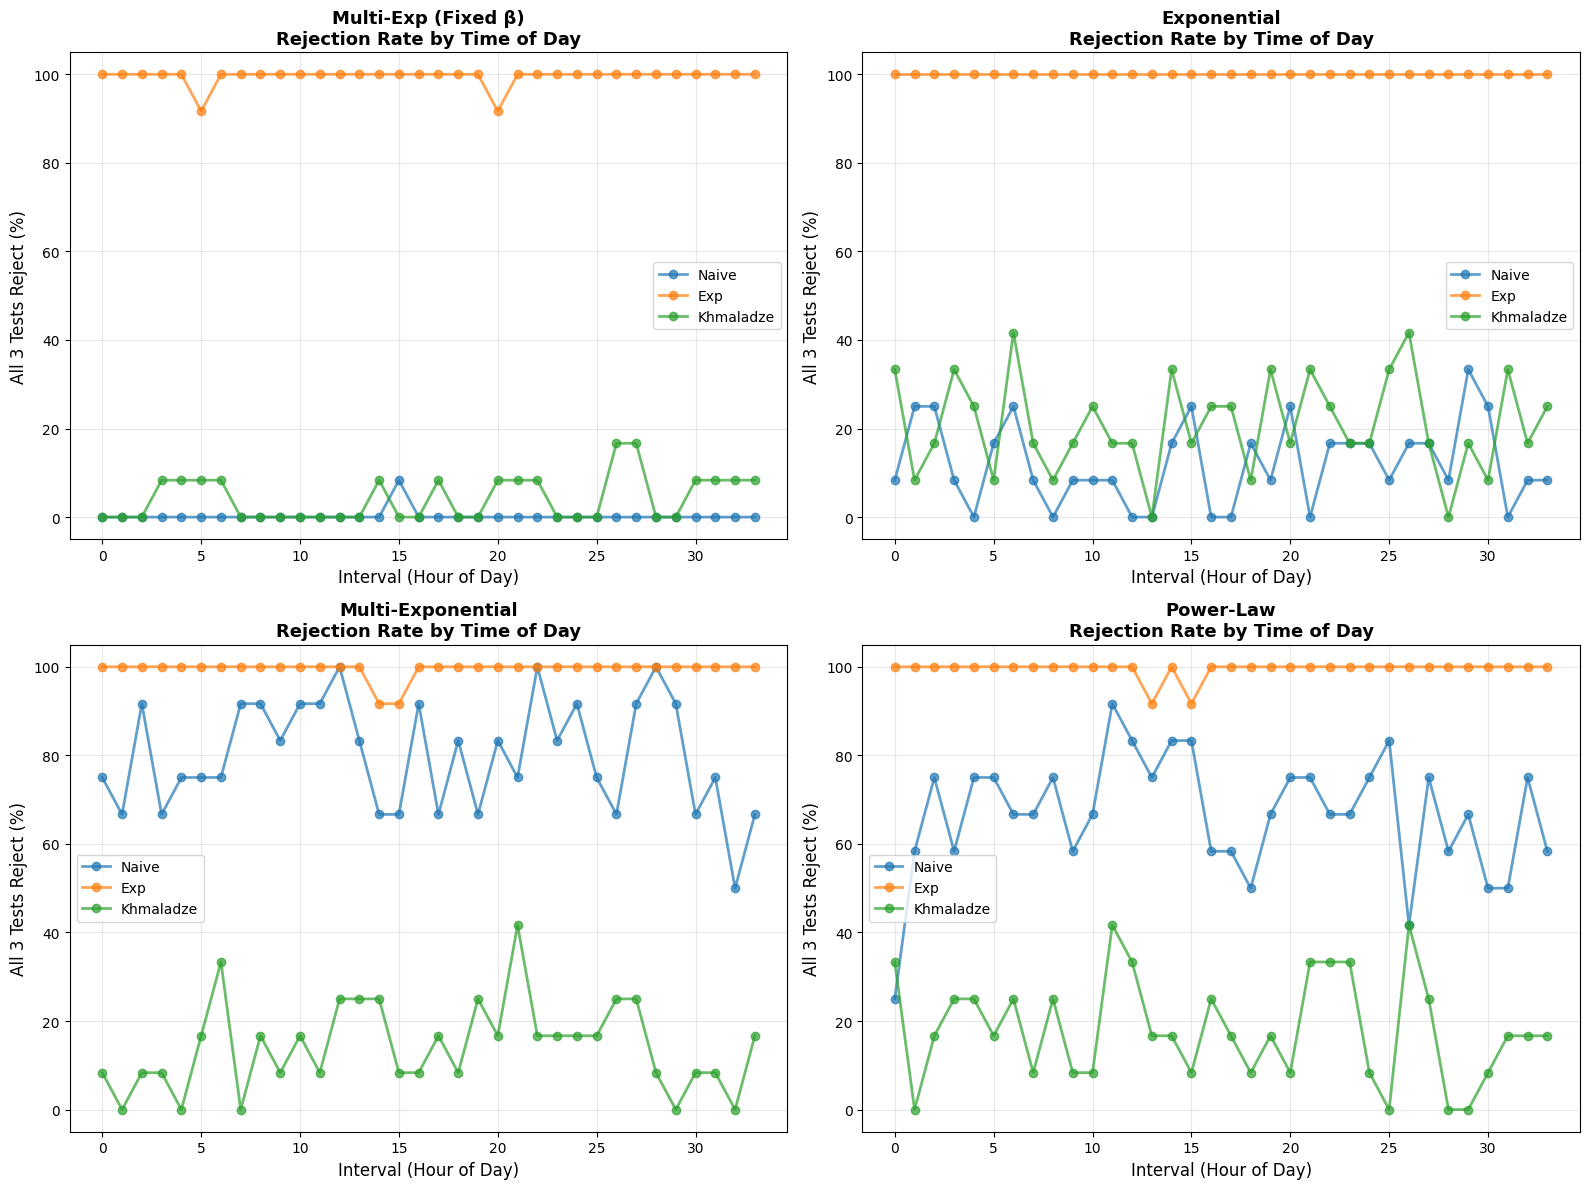


Visualization saved as 'rejection_patterns_by_time.png'

Interpretation:
- Patterns across intervals may reveal time-of-day effects
- If rejection rates vary dramatically by hour, data is non-stationary
- If one method consistently rejects more, it may be more sensitive to model violations


In [133]:
# Visualize rejection patterns across time and models
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

models = [
    (df_fixed, "Multi-Exp (Fixed β)", 0),
    (df_exp, "Exponential", 1),
    (df_multi, "Multi-Exponential", 2),
    (df_pl, "Power-Law", 3)
]

for df, name, idx in models:
    if df is None:
        continue
    
    ax = axes[idx]
    
    # Calculate rejection rate by interval (time of day)
    df_plot = df.copy()
    df_plot['interval_idx'] = df_plot.index.str.split('_').str[-1].astype(int) if isinstance(df_plot.index[0], str) else df_plot['interval_idx']
    
    # Aggregate by interval
    interval_data = []
    for interval in sorted(df_plot['interval_idx'].unique()):
        subset = df_plot[df_plot['interval_idx'] == interval]
        
        for method in ['naive', 'exp', 'khmaladze']:
            n_total = subset[f'ks_reject_{method}'].notna().sum()
            if n_total > 0:
                # Count how many intervals had all 3 tests reject
                all_reject = (subset[f'ks_reject_{method}'] & 
                             subset[f'ad_reject_{method}'] & 
                             subset[f'cvm_reject_{method}']).sum()
                interval_data.append({
                    'interval': interval,
                    'method': method.capitalize(),
                    'rejection_rate': all_reject / n_total * 100
                })
    
    df_interval = pd.DataFrame(interval_data)
    
    # Plot
    for method in ['Naive', 'Exp', 'Khmaladze']:
        subset = df_interval[df_interval['method'] == method]
        ax.plot(subset['interval'], subset['rejection_rate'], 
               marker='o', label=method, alpha=0.7, linewidth=2)
    
    ax.set_xlabel('Interval (Hour of Day)', fontsize=12)
    ax.set_ylabel('All 3 Tests Reject (%)', fontsize=12)
    ax.set_title(f'{name}\nRejection Rate by Time of Day', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-5, 105)

plt.tight_layout()
plt.savefig('rejection_patterns_by_time.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'rejection_patterns_by_time.png'")
print("\nInterpretation:")
print("- Patterns across intervals may reveal time-of-day effects")
print("- If rejection rates vary dramatically by hour, data is non-stationary")
print("- If one method consistently rejects more, it may be more sensitive to model violations")